# XPCS Notebook 
This notebook demonstrates how to search and analyze data from Globus Search

In [4]:
## Globus client ID and portal ID
CLIENT_ID = "04dc20ba-d8e4-4a9a-9cc9-3ed3f3d49447" 
# INDEX_ID = "6871e83e-866b-41bc-8430-e3cf83b43bdc" # Old XPCS index.
INDEX_ID = "4428cfe6-611b-48db-81b2-167a7d9710ea"
ENDPOINT_ID = "74defd5b-5f61-42fc-bcc4-834c9f376a4f"  # Your endpoint ID
HTTPS_PATH = "https://g-f6125.fd635.8443.data.globus.org"
LOCAL_PATH = None #'/eagle/projects/XPCS-DATA-DYS' # Local path to save the files

## globus client setup
import globus_sdk

app = globus_sdk.UserApp(
    app_name="Notebook Main App",
    client_id=CLIENT_ID)

search_client = globus_sdk.SearchClient(app=app)
https_scope = f"https://auth.globus.org/scopes/{ENDPOINT_ID}/https"
app.add_scope_requirements({"{COLLECTION_ID}": https_scope})
token = app.get_authorizer(ENDPOINT_ID).access_token
##

def make_query(query, field_name='dc.identifiers.identifier', filter_value='*', limit=20, offset=0):
    """
    Make a single query to Globus Search with pagination support.

    Args:
        query (str): Search query string
        field_name (str): Field name to filter on
        filter_value (str): Filter value pattern
        limit (int): Number of results per page
        offset (int): Offset for pagination

    Returns:
        dict: Search response from Globus
    """
    query_data = {
        'q': query,
        'limit': limit,
        'offset': offset,
        'advanced': True,
        'filters': [
            {
                "type": "like",
                "field_name": field_name,
                "value": filter_value
            }
        ]
    }
    print(f"Query data: {query_data}")
    response = search_client.post_search(
        index_id=INDEX_ID,
        data=query_data
    )
    print(f"Query results: {response['total']} total, {len(response['gmeta'])} in this page")
    return response


def make_paginated_query(query, field_name='dc.identifiers.identifier', filter_value='*', 
                        limit=20, max_results=None):
    """
    Make a paginated query to fetch all results across multiple pages.

    Args:
        query (str): Search query string
        field_name (str): Field name to filter on
        filter_value (str): Filter value pattern
        limit (int): Number of results per page
        max_results (int, optional): Maximum number of results to fetch

    Returns:
        list: List of all search results across all pages
    """
    all_results = []
    offset = 0
    total_fetched = 0

    # Get first page to determine total results
    first_response = make_query(query, field_name, filter_value, limit, offset)
    total_results = first_response['total']

    if total_results == 0:
        print("No results found")
        return []

    # Add first page results
    all_results.extend(first_response['gmeta'])
    total_fetched += len(first_response['gmeta'])

    print(f"Fetched page 1: {len(first_response['gmeta'])} results")

    # Continue fetching subsequent pages
    page = 2
    while True:
        offset += limit

        # Check if we've reached max_results limit
        if max_results and total_fetched >= max_results:
            print(f"Reached max_results limit: {max_results}")
            break

        # Check if we've fetched all results
        if total_fetched >= total_results:
            print(f"Fetched all {total_results} results")
            break

        # Fetch next page
        response = make_query(query, field_name, filter_value, limit, offset)
        page_results = response['gmeta']

        if not page_results:  # No more results
            break

        all_results.extend(page_results)
        total_fetched += len(page_results)

        print(f"Fetched page {page}: {len(page_results)} results (Total: {total_fetched}/{total_results})")
        page += 1

    print(f"Pagination complete: {len(all_results)} total results fetched")
    return all_results


Please authenticate with Globus here:
-------------------------------------
https://auth.globus.org/v2/oauth2/authorize?client_id=04dc20ba-d8e4-4a9a-9cc9-3ed3f3d49447&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=https%3A%2F%2Fauth.globus.org%2Fscopes%2F74defd5b-5f61-42fc-bcc4-834c9f376a4f%2Fhttps+urn%3Aglobus%3Aauth%3Ascope%3Asearch.api.globus.org%3Asearch+openid&state=_default&response_type=code&code_challenge=s_J55HwL5UbUXjfe8h48agJmFUWXGtwHf57n2NgSloI&code_challenge_method=S256&access_type=online&prefill_named_grant=Notebook+Main+App+on+ripchip
-------------------------------------



In [5]:
## This is the wrong query, just for testing
query = "bacon"  # Match all entries (or a specific keyword)
make_query(query=query)

Query data: {'q': 'bacon', 'limit': 20, 'offset': 0, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 0 total, 0 in this page


GlobusHTTPResponse({"total":0,"gmeta":[],"@datatype":"GSearchResult","@version":"2017-09-01","offset":0,"count":0,"has_next_page":false})

In [6]:
## Full Milliron query
query = "milliron"  # Match all entries (or a specific keyword)
milli_response = make_query(query = query)

Query data: {'q': 'milliron', 'limit': 20, 'offset': 0, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 21971 total, 20 in this page


In [37]:
# Test paginated query (fetch first 40 results in two pages of 20)
query = "milliron"
paginated_results = make_paginated_query(query=query, limit=20, max_results=5000)
print(f"Total results fetched with pagination: {len(paginated_results)}")

Query data: {'q': 'milliron', 'limit': 20, 'offset': 0, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 21971 total, 20 in this page
Fetched page 1: 20 results
Query data: {'q': 'milliron', 'limit': 20, 'offset': 20, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 21971 total, 20 in this page
Fetched page 2: 20 results (Total: 40/21971)
Query data: {'q': 'milliron', 'limit': 20, 'offset': 40, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 21971 total, 20 in this page
Fetched page 3: 20 results (Total: 60/21971)
Query data: {'q': 'milliron', 'limit': 20, 'offset': 60, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*'}]}
Query results: 21971 total, 20 in this page
Fetched page 4: 20 results (Total: 80/21971)
Query data:

In [38]:
# Loop through all paginated results and print identifiers
print("Printing identifiers for all results:")
print("=" * 50)

for i, result in enumerate(paginated_results, 1):
    # Extract identifier from the result
    try:
        # The identifier is typically in the 'subject' field
        identifier = result.get('subject', 'No subject found')
        #print(f"{i:4d}. {identifier}")
    except Exception as e:
        print(f"{i:4d}. Error extracting identifier: {e}")

print("=" * 50)
print(f"Total results processed: {len(paginated_results)}")

Printing identifiers for all results:
Total results processed: 5000


In [39]:
# Loop through all paginated results and extract title and temperature
print("Extracting title and temperature for all results:")
print("=" * 80)

results_data = {}

for i, result in enumerate(paginated_results, 1):
    try:
        # Extract title from ['dc']['titles'][0]['title']
        title = result['entries'][0]['content']['dc']['titles'][0]['title']
        

        # Extract temperature from 'project_metadata./entry/sample.qnw1_temperature'
        temp = result['entries'][0]['content']['project_metadata']['/entry/sample']['qnw1_temperature_set']
        
        # Store in dictionary with index as key
        results_data[i] = {
            'title': title,
            'temp': temp
        }
        
        # print(f"{i:4d}. Title: {title}")
        # print(f"     Temp: {temp}")
        # print()
        
    except Exception as e:
        print(f"{i:4d}. Error extracting data: {e}")
        results_data[i] = {
            'title': 'Error extracting title',
            'temp': 'Error extracting temperature'
        }

print("=" * 80)
print(f"Total results processed: {len(results_data)}")

Extracting title and temperature for all results:
Total results processed: 5000


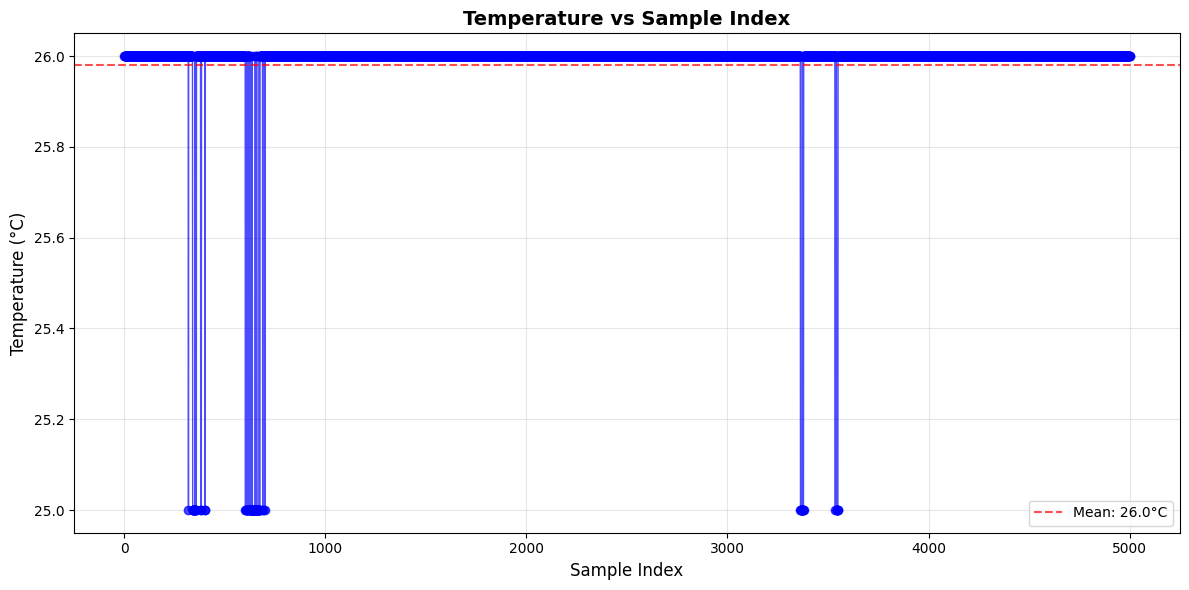

Temperature Statistics:
Mean: 25.98°C
Std: 0.14°C
Min: 25.00°C
Max: 26.00°C
Unique temperatures: [25. 26.]


In [40]:
# Plot temperature vs titles
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
titles = [results_data[i]['title'] for i in range(1, len(results_data) + 1)]
temperatures = [results_data[i]['temp'] for i in range(1, len(results_data) + 1)]

# Create x-axis positions (just numbers)
x_positions = np.arange(1, len(titles) + 1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x_positions, temperatures, 'bo-', markersize=6, linewidth=1, alpha=0.7)

# Customize the plot
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Temperature vs Sample Index', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Set x-axis to show sample numbers instead of title names
#plt.xticks(x_positions, [f'Sample {i}' for i in x_positions], rotation=45, ha='right')

# Add some statistics
temp_array = np.array(temperatures)
plt.axhline(y=np.mean(temp_array), color='r', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(temp_array):.1f}°C')
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Temperature Statistics:")
print(f"Mean: {np.mean(temp_array):.2f}°C")
print(f"Std: {np.std(temp_array):.2f}°C")
print(f"Min: {np.min(temp_array):.2f}°C")
print(f"Max: {np.max(temp_array):.2f}°C")
print(f"Unique temperatures: {np.unique(temp_array)}")